In [63]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from basic_pitch.inference import predict
from basic_pitch import ICASSP_2022_MODEL_PATH

In [64]:
DATA_DIR = "data"
SAMPLE_RATE = 16000

In [65]:
df = pd.DataFrame([(f, *librosa.load(os.path.join(DATA_DIR, f), sr=SAMPLE_RATE)) for f in os.listdir(DATA_DIR) if f.endswith(".wav")], columns=["filename", "audio", "sr"])

In [66]:
y = df.iloc[0]["audio"][:60000]

In [67]:
ipd.Audio(y, rate=SAMPLE_RATE)

C:\Users\demat\AppData\Local\Temp\ipykernel_26308\218799790.py:6: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y, sr=SAMPLE_RATE, x_axis='time')


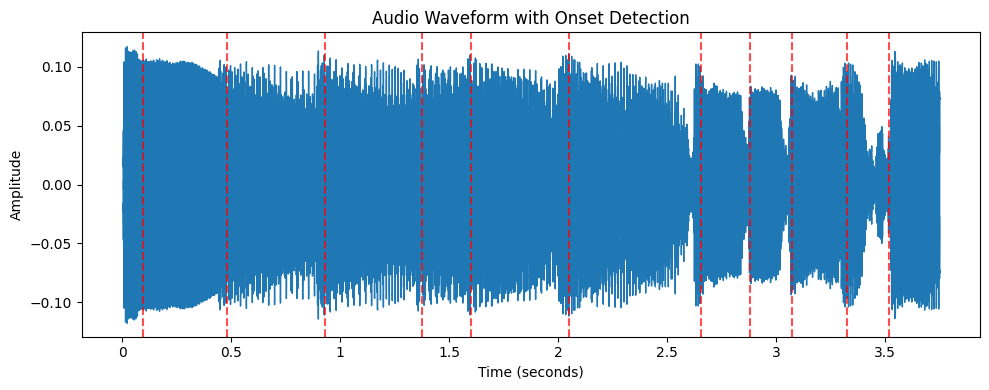

[0.    0.096 0.48  0.928 1.376 1.6   2.048 2.656 2.88  3.072 3.328 3.52
 3.75 ]
[0.096 0.48  0.928 1.376 1.6   2.048 2.656 2.88  3.072 3.328 3.52 ]


[('D3', 0.0, 0.096), ('D3', 0.096, 0.48), ('D♯3', 0.48, 0.928), ('A3', 0.928, 1.376), ('G3', 1.376, 1.6), ('G2', 1.6, 2.048), ('A3', 2.048, 2.656), ('C♯3', 2.656, 2.88), ('B2', 2.88, 3.072), ('A2', 3.072, 3.328), ('G♯2', 3.328, 3.52), ('F♯2', 3.52, 3.75)]
Predicting MIDI for 1.wav...


ValueError: File D:\code\AI\Emotions\.venv\Lib\site-packages\basic_pitch\saved_models\icassp_2022\nmp cannot be loaded into either TensorFlow, CoreML, TFLite or ONNX. Please check if it is a supported and valid serialized model and that one of these packages are installed. On this system, ['TensorFlow', 'TensorFlowLite', 'ONNX'] is installed.

In [68]:

onset_frames = librosa.onset.onset_detect(y=y, sr=SAMPLE_RATE, wait=5, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
onset_times = librosa.frames_to_time(onset_frames, sr=SAMPLE_RATE)
boundaries = np.concatenate([[0], onset_times, [librosa.get_duration(y=y, sr=SAMPLE_RATE)]])

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=SAMPLE_RATE, x_axis='time')
#plot amplitude of the audio with onset detection
for t in onset_times:
    plt.axvline(x=t, color='r', linestyle='--', alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Audio Waveform with Onset Detection")
plt.tight_layout()
plt.show()

print(boundaries)
print(onset_times)

results = []
for i in range(len(boundaries) - 1):
    start, end = boundaries[i], boundaries[i+1]
    chunk = y[int(start*SAMPLE_RATE):int(end*SAMPLE_RATE)]
    if len(chunk) == 0: continue

    # 2. Estimate the Fundamental Frequency (f0)
    # fmin and fmax are set to a standard guitar range (approx E2 to B5)
    f0, voiced_flag, voiced_probs = librosa.pyin(chunk,
                                                 fmin=librosa.note_to_hz('E2'),
                                                 fmax=librosa.note_to_hz('C6'),
                                                 sr=SAMPLE_RATE)

    # 3. Clean up the f0 data (ignore NaNs)
    f0_clean = f0[~np.isnan(f0)]

    if len(f0_clean) > 0:
        # Use the median frequency to avoid outliers from string buzz
        median_f0 = np.median(f0_clean)

        # 4. Convert Hz to Note Name with Octave (e.g., "A4")
        note_name = librosa.hz_to_note(median_f0)

        results.append((note_name, round(float(start), 3), round(float(end), 3)))
print(results)


# note_events is a list of: (start_time_s, end_time_s, pitch_midi, amplitude, pitch_bend)
model_output, midi_data, note_events = predict(df.iloc[0]["filename"])

results = []
for start, end, pitch, amp, bend in note_events:
    note_name = librosa.midi_to_note(int(pitch))
    results.append((note_name, round(start, 3), round(end, 3)))

# Sort by start time
print(sorted(results, key=lambda x: x[1]))